# Pre-processing and data augmentation for bounding boxes
Data augmentation is the most important way to avoid overfitting for image classification tasks. <br>

In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import torch
from pathlib import Path
from torch.utils.data import Dataset, DataLoader
import random

In [2]:
import cv2
import matplotlib.pyplot as plt 

In [5]:
PATH = Path("/data2/yinterian/fisheries")

In [3]:
import math
def crop(im, r, c, target_r, target_c): return im[r:r+target_r, c:c+target_c]

# random crop to the original size
def random_crop(x, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    return crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)

def center_crop(x, r_pix=8):
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    return crop(x, r_pix, c_pix, r-2*r_pix, c-2*c_pix)


def rotate_cv(im, deg, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, 
                          flags=cv2.WARP_FILL_OUTLIERS+interpolation)

## Bounding boxes and Y transforms
In some problems if you transform the image the $y$ should be transformed as well. The data for this part comes from the [Kaggle fisheries competition](https://www.kaggle.com/c/the-nature-conservancy-fisheries-monitoring). The competition asks you to detect which species of fish appears on a fishing boat, based on images captured from boat cameras of various angles. One of the competitors hand labeled bounding box data. Here is how the data looks like:

In [8]:
def read_image(path):
    im = cv2.imread(str(path))
    return cv2.cvtColor(im, cv2.COLOR_BGR2RGB)

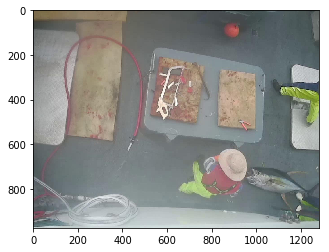

In [9]:
path = PATH/"train/YFT/img_02642.jpg"
im = read_image(path) 
plt.imshow(im)

In [10]:
bb = np.array([699.399, 954.697, 895.326, 1275.3])

In [11]:
def create_corner_rect(bb, color='red'):
    bb = np.array(bb, dtype=np.float32)
    return plt.Rectangle((bb[1], bb[0]), bb[3]-bb[1], bb[2]-bb[0], color=color,
                         fill=False, lw=3)

def show_corner_bb(im, bb):
    plt.imshow(im)
    plt.gca().add_patch(create_corner_rect(bb))

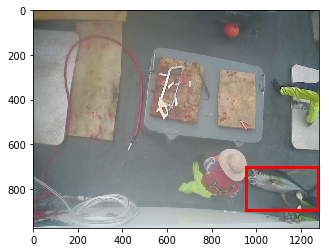

In [12]:
show_corner_bb(im, bb)

### Transforming Y

Suppose that your task is to predict the bounding box for the fish. If that is the case for image augmentation you also need to trasform the bounding box. One strategy is to transform the bounding box to a 2D image of the same dimension of X and treat the bounding box as points in that image. Let's implement some of these transforms.

In [98]:
# These helper functions transforms to and from bounding boxes

def coords2px(y, x_shape):
    """ Transforming bounding boxes to pixels"""
    rows = np.rint([y[0], y[0], y[2], y[2]]).astype(int)
    cols = np.rint([y[1], y[3], y[1], y[3]]).astype(int)
    r,c,*_ = x_shape
    Y = np.zeros((r, c))
    Y[rows, cols] = 1
    return Y

def make_bb_px(y, x_shape):
    """ Makes an image of size x retangular bounding box"""
    r,c,*_ = x_shape
    Y = np.zeros((r, c))
    y = y.astype(np.int)
    Y[y[0]:y[2], y[1]:y[3]] = 1.
    return Y

def to_bb(Y):
    """Convert mask Y to a bounding box, assumes 0 as background nonzero object"""
    cols, rows = np.nonzero(Y)
    if len(cols)==0: return np.zeros(4, dtype=np.float32)
    top_row = np.min(rows)
    left_col = np.min(cols)
    bottom_row = np.max(rows)
    right_col = np.max(cols)
    return np.array([left_col, top_row, right_col, bottom_row], dtype=np.float32)

In [99]:
Y = coords2px(bb, im.shape)
print(Y.shape)
print(im.shape)

(300, 533)
(300, 533, 3)


In [100]:
print(bb)
to_bb(Y)

[125.  73. 168. 180.]


array([125.,  73., 168., 180.], dtype=float32)

In [101]:
Y = make_bb_px(bb, im.shape)
to_bb(Y)

array([125.,  73., 167., 179.], dtype=float32)

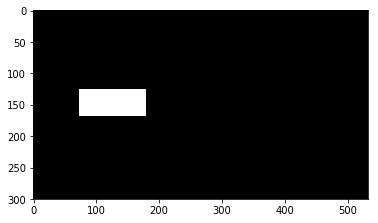

In [102]:
plt.imshow(Y, cmap='gray')

### Resize

In [103]:
def resize_tr(im, bb, sz=(533, 300)):
    Y = make_bb_px(bb, im.shape)
    im2 = cv2.resize(im, sz)
    Y2 = cv2.resize(Y, sz)
    return im2, to_bb(Y2)

In [33]:
im2, bb2 = resize_tr(im, bb)
bb2

array([215., 397., 275., 530.], dtype=float32)

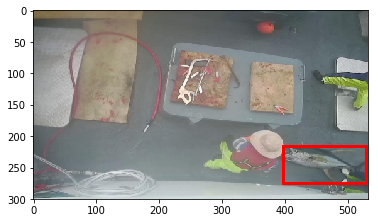

In [34]:
show_corner_bb(im2, bb2)

### Rotate
To get this to work well we have to re-write rotate.

In [35]:
def rotate_cv(im, deg, y=False, mode=cv2.BORDER_REFLECT, interpolation=cv2.INTER_AREA):
    """ Rotates an image by deg degrees"""
    r,c,*_ = im.shape
    M = cv2.getRotationMatrix2D((c/2,r/2),deg,1)
    if y:
        return cv2.warpAffine(im, M,(c,r), borderMode=cv2.BORDER_CONSTANT)
    return cv2.warpAffine(im,M,(c,r), borderMode=mode, flags=cv2.WARP_FILL_OUTLIERS+interpolation)

In [36]:
def rotate_tr(im, bb, deg):
    rdeg = 2*(np.random.random()-.50)*deg
    print(rdeg)
    Y = make_bb_px(bb, im)
    im_rot = rotate_cv(im, rdeg)
    Y_rot = rotate_cv(Y, rdeg, y=True)
    return im_rot, to_bb(Y_rot)   

In [37]:
im2, bb2 = rotate_tr(im, bb, 20)
bb2

11.770892054417509


array([ 570.,  990.,  822., 1279.], dtype=float32)

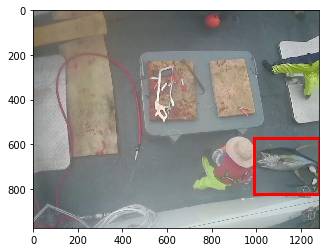

In [38]:
show_corner_bb(im2, bb2)

## Random Flip
Write this one

# Prepocessing fish data

## Resizing data

In [40]:
from collections import Counter
# let's look at the typical size of these images
files = list((PATH/"train/ALB/").iterdir()) + list((PATH/"train/SHARK/").iterdir())
dims = [read_image(str(p)).shape for p in files]
counts = Counter(dims)
counts

Counter({(720, 1280, 3): 1163,
         (854, 1518, 3): 6,
         (670, 1192, 3): 164,
         (750, 1280, 3): 330,
         (974, 1280, 3): 87,
         (718, 1276, 3): 109,
         (924, 1280, 3): 34,
         (700, 1244, 3): 2})

In [41]:
[(k[1]/k[0], counts[k]) for k in counts]

[(1.7777777777777777, 1163),
 (1.7775175644028103, 6),
 (1.7791044776119402, 164),
 (1.7066666666666668, 330),
 (1.3141683778234086, 87),
 (1.777158774373259, 109),
 (1.3852813852813852, 34),
 (1.7771428571428571, 2)]

In [42]:
def resize_images(path, sz=300):
    im = read_image(path)
    sz2 = int(1.778*sz)
    return cv2.resize(im, (sz2, sz))

(300, 533, 3)

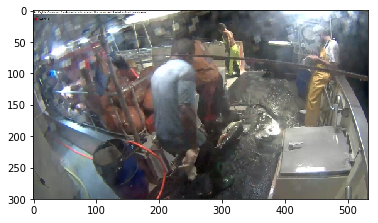

In [44]:
path = PATH/"train/ALB/img_02140.jpg"
im = resize_images(path)
plt.imshow(im)
im.shape

In [45]:
train_path = PATH/"train-300"
valid_path = PATH/"valid-300"

train_path.mkdir(exist_ok=True)
valid_path.mkdir(exist_ok=True)

In [46]:
def resize_all_images(train_path, valid_path, org_path, sz=300):
    np.random.seed(3)
    paths = [x for x in list(org_path.iterdir()) if x.is_dir()]
    for p in paths:
        label = p.parts[-1]
        (train_path/label).mkdir(exist_ok=True)
        (valid_path/label).mkdir(exist_ok=True) 
        files = list((org_path/label).iterdir())
        for f in files:
            f_name = f.parts[-1]
            if np.random.uniform() < 0.8:
                new_path = train_path/label/f_name
            else:
                new_path = valid_path/label/f_name
            im = resize_images(f)
            cv2.imwrite(str(new_path), cv2.cvtColor(im, cv2.COLOR_RGB2BGR))

In [47]:
#run just the first time
#resize_all_images(train_path, valid_path, PATH/"train")

In [70]:
train_path=PATH/"train-300"
paths = [d for d in list(train_path.iterdir()) if d.is_dir()]
files = [f for d in paths for f in list(d.iterdir())]
labels = [p.parts[-1] for p in paths]
label2ind = {v:k for k,v in enumerate(labels)}

In [71]:
label2ind 

{'DOL': 0,
 'NoF': 1,
 'LAG': 2,
 'SHARK': 3,
 'OTHER': 4,
 'BET': 5,
 'YFT': 6,
 'ALB': 7}

## Getting bounding box data
A kaggle user has created bounding boxes for most fish in the training set. Here is a link to download them. We will use the bounding boxes by training a model to not only predict the class of the fish but also the bounding box. The data is no longer available online so I upload it in **canvas**.

In [120]:
# download annotations (THIS is not working at the moment use data in canvas)
import ujson as json
import requests
url_prefix = 'https://kaggle2.blob.core.windows.net/forum-message-attachments/147157/'
annot_urls = {
        '5458/bet_labels.json': 'bd20591439b650f44b36b72a98d3ce27',
        '5459/shark_labels.json': '94b1b3110ca58ff4788fb659eda7da90',
        '5460/dol_labels.json': '91a25d29a29b7e8b8d7a8770355993de',
        '5461/yft_labels.json': '9ef63caad8f076457d48a21986d81ddc',
        '5462/alb_labels.json': '731c74d347748b5272042f0661dad37c',
        '5463/lag_labels.json': '92d75d9218c3333ac31d74125f2b380a'
    }

def download_annotations():
    anno_dir = PATH/"annotations"
    anno_dir.mkdir(exist_ok=True)
    for url_suffix in annot_urls:
        url = url_prefix + url_suffix
        r = requests.get(url, allow_redirects=True)
        json_file = url_suffix.split("/")[1]
        open(anno_dir/json_file, 'wb').write(r.content)
#download_annotations()

In [79]:
list((PATH/"annotations").iterdir())

[PosixPath('/data2/yinterian/fisheries/annotations/shark_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/yft_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/alb_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/lag_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/bet_labels.json'),
 PosixPath('/data2/yinterian/fisheries/annotations/dol_labels.json')]

In [67]:
def get_annotations(path=PATH/"annotations"):
    bb_json = {}
    jfiles = list((PATH/"annotations").iterdir())
    for f in jfiles:
        j = json.load(open(f, 'r'))
        for l in j:
            if 'annotations' in l.keys() and len(l['annotations'])>0:
                bb_json[l['filename'].split('/')[-1]] = sorted(
                    l['annotations'], key=lambda x: x['height']*x['width'])[-1]
    return bb_json

In [68]:
bb_json = get_annotations()

In [69]:
bb_json["img_02140.jpg"]

{'class': 'rect',
 'height': 137.74236820964148,
 'width': 129.43032874871483,
 'x': 704.1484857613566,
 'y': 398.9778941244786}

In [89]:
def bb_json2bb(im_name):
    x = bb_json[im_name]
    return [x['y'], x['x'], x['y'] + x['height'], x['x']+ x['width']]

In [90]:
bb_json2bb("img_02140.jpg")

[398.9778941244786, 704.1484857613566, 536.7202623341201, 833.5788145100714]

## Transforming bounding box data after resizing

In [80]:
## compute the size of the original images
def get_shape_original_images():
    paths = [d for d in list((PATH/"train").iterdir()) if d.is_dir()]
    files = [f for d in paths for f in list(d.iterdir())]
    shapes = {f.parts[-1]: cv2.imread(str(f)).shape for f in files}
    return shapes
shapes = get_shape_original_images()

In [81]:
shapes["img_02140.jpg"]

(720, 1280, 3)

In [104]:
def resize_bb(orig_shape, bb, sz=(533, 300)):
    Y = make_bb_px(bb, orig_shape)
    Y2 = cv2.resize(Y, sz)
    return to_bb(Y2)

In [87]:
## computes bounding boxes for the resized data
bb_json_300 = {}
for name in bb_json:
    orig_shape = shapes[name]
    x = bb_json[name]
    bb = [x['y'], x['x'], x['y'] + x['height'], x['x']+ x['width']]
    bb_json_300[name] = resize_bb(orig_shape, np.array(bb)) 

In [88]:
bb_json_300["img_02140.jpg"]

array([166., 293., 223., 346.], dtype=float32)

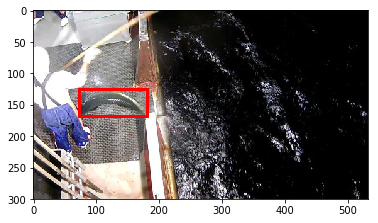

In [97]:
path = PATH/"train-300/DOL/img_00983.jpg"
im = read_image(path)
bb = bb_json_300["img_00983.jpg"]
show_corner_bb(im, bb)

In [93]:
import pickle 
with open(PATH/'bb_json_300.pkl','wb') as f:
    pickle.dump(bb_json_300, f)

## Fish Dataset

In [95]:
with open(PATH/'bb_json_300.pkl','rb') as f:
    bb_json_300 = pickle.load(f)

In [111]:
def random_cropXY(x, Y, r_pix=8):
    """ Returns a random crop"""
    r, c,*_ = x.shape
    c_pix = round(r_pix*c/r)
    rand_r = random.uniform(0, 1)
    rand_c = random.uniform(0, 1)
    start_r = np.floor(2*rand_r*r_pix).astype(int)
    start_c = np.floor(2*rand_c*c_pix).astype(int)
    xx = crop(x, start_r, start_c, r-2*r_pix, c-2*c_pix)
    YY = crop(Y, start_r, start_c, r-2*r_pix, c-2*c_pix)
    return xx, YY

In [112]:
def transformsXY(path, bb, transforms):
    x = cv2.imread(str(path)).astype(np.float32)
    x = cv2.cvtColor(x, cv2.COLOR_BGR2RGB)/255
    Y = make_bb_px(bb, x.shape)
    if transforms:
        rdeg = (np.random.random()-.50)*20
        x = rotate_cv(x, rdeg)
        Y = rotate_cv(Y, rdeg, y=True)
        if np.random.random() > 0.5: 
            x = np.fliplr(x).copy()
            Y = np.fliplr(Y).copy()
        x, Y = random_cropXY(x, Y)
    else:
        x, Y = center_crop(x), center_crop(Y)
    return x, to_bb(Y)

In [118]:
x1, bb1 = transformsXY(path, bb, True)

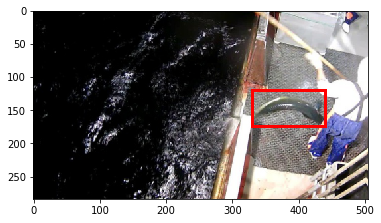

In [119]:
show_corner_bb(x1, bb1)